In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [2]:
#Select Caases from where cross validation is performed 
cases = [#'DUCT_1100',
         #'DUCT_1150',
         #'DUCT_1250',
         #'DUCT_1300',
         #'DUCT_1350',
         #'DUCT_1400',
         #'DUCT_1500',
         #'DUCT_1600',
         #'DUCT_1800',
         #'DUCT_2000',
         #'DUCT_2205',
         #'DUCT_2400',
         #'DUCT_2600',
         #'DUCT_2900',
         #'DUCT_3200',
         #'DUCT_3500',
         'PHLL_case_0p5',
         'PHLL_case_0p8',
         'PHLL_case_1p0',
         'PHLL_case_1p2',
         'PHLL_case_1p5',
         # 'BUMP_h20',
         # 'BUMP_h26',
         # 'BUMP_h31',
         # 'BUMP_h38',
         # 'BUMP_h42',
         # 'CNDV_12600',
         # 'CNDV_20580',
         # 'CBFS_13700'
         ]

#cases = ['DUCT_1100',]

dataset = 'komegasst' 

parent_directory = 'D:\\OneDrive - Universidade de Lisboa\\Turbulence Modelling Database\\' + dataset

basis_name ='a_3_1_2_NL_S_DNS_eV_01'

viscosity = 5e-6

TroubleShoot = False

In [3]:
def build_47_I1(tensor_basis):
    I1 = np.zeros(tensor_basis.shape[0]*20).reshape(tensor_basis.shape[0], 20)
    for j in range(tensor_basis.shape[0]):
        for i in range(20):
            I1[j, i] = np.trace(tensor_basis[j, i])
    return I1

def build_47_I2(tensor_basis, I1):
    I2 = np.zeros(tensor_basis.shape[0]*20).reshape(tensor_basis.shape[0], 20)
    for j in range(tensor_basis.shape[0]):
        for i in range(20):
            I2[j, i] = 0.5*(I1[j, i]**2 - np.trace(np.matmul(tensor_basis[j, i], tensor_basis[j, i])))
    return I2

In [4]:
#Convenient functions for loading dataset
def loadCombinedArray(cases,field):
    data = np.concatenate([np.load('D:\\OneDrive - Universidade de Lisboa\\Turbulence Modelling Database\\'+dataset+'\\'+dataset+'_'+case+'_'+field + '.npy') for case in cases])
    return data

def loadCombinedArray_47(cases, field):
    data = np.concatenate([np.load(parent_directory + '\\' + basis_name + '\\'+ dataset+'_'+case+'_'+ field + '.npy') for case in cases])
    return data

def loadLabels(cases,field):
    data = np.concatenate([np.load('D:\\OneDrive - Universidade de Lisboa\\Turbulence Modelling Database\\labels\\'+case+'_'+field + '.npy') for case in cases])
    return data

def build_a(case):   
        
    tau = loadLabels(case, 'tau')
     
    tau = np.concatenate(tau).reshape(len(tau), 3, 3)
          
    a = np.concatenate([tau[i] - 1/3*np.trace(tau[i])*np.identity(3) for i in range(tau.shape[0])]).reshape(tau.shape[0], 3,3)  
    #Zero non 2D entries
    #S[:, 0, 2] = 0
    #S[:, 1, 2] = 0
    #S[:, 2, 0] = 0
    #S[:, 2, 1] = 0
    #S[:, 2, 2] = 0
    
    return a


def build_S_DNS(case):
    S_DNS = loadCombinedArray([case], 'S_DNS')
    return S_DNS
    
    
def build_47_tensors_basis(cases):
    #Fields to load from dataset will be Shat, Rhat, Akhat, Aphat
    # Shat Symmetric and the remaining are Antisymmetric
    Shat = loadCombinedArray(cases, 'Shat')
    Rhat = loadCombinedArray(cases, 'Rhat')
    Akhat = loadCombinedArray(cases, 'Akhat')
    #Aphat = loadCombinedArray(cases, 'Aphat')
    
    max_index = Shat.shape[0]
      
    #### b_20, b_26, b_30, b_32 and b_39 values do not match the values provided in the invariants (i_n = tr(b_n))  
    #### given that all these are meant to be zero as showed by McKonkey et all and the values calculated are inferior than 1e-15, nothing was done to change them
    #### Something to test would be to set those invariants to zero naturally and see what happens
    
    b_1 = np.concatenate([np.linalg.multi_dot([Shat[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #print(f'b1\n{b_1}\n')
    #print(np.concatenate([np.linalg.multi_dot([Shat[i], Shat[i]]) for i in range(max_index)]))
    
    b_2 = np.concatenate([np.linalg.multi_dot([b_1[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #print(f'b2\n{b_2}\n')
    
    
    b_3 = np.concatenate([np.linalg.multi_dot([Rhat[i], Rhat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_4 = np.concatenate([np.linalg.multi_dot([Aphat[i], Aphat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    b_5 = np.concatenate([np.linalg.multi_dot([Akhat[i], Akhat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    
    b_6 = np.concatenate([np.linalg.multi_dot([b_3[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    b_7 = np.concatenate([np.linalg.multi_dot([b_3[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    b_8 = np.concatenate([np.linalg.multi_dot([b_6[i], Rhat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_9 = np.concatenate([np.linalg.multi_dot([b_4[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_10 = np.concatenate([np.linalg.multi_dot([b_4[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_11 = np.concatenate([np.linalg.multi_dot([b_4[i], Shat[i], Aphat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    b_12 = np.concatenate([np.linalg.multi_dot([b_5[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    b_13 = np.concatenate([np.linalg.multi_dot([b_5[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    b_14 = np.concatenate([np.linalg.multi_dot([b_5[i], Shat[i], Akhat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    
    #b_15 = np.concatenate([np.linalg.multi_dot([Rhat[i], Aphat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_16 = np.concatenate([np.linalg.multi_dot([Aphat[i], Akhat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    b_17 = np.concatenate([np.linalg.multi_dot([Rhat[i], Akhat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    
    #b_18 = np.concatenate([np.linalg.multi_dot([b_15[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_19 = np.concatenate([np.linalg.multi_dot([b_15[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #!!!!!!
    #b_20 = np.concatenate([np.linalg.multi_dot([b_3[i], Aphat[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) ### Cyclic Permutation
    #b_21 = np.concatenate([np.linalg.multi_dot([b_4[i], Rhat[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) ### Cyclic Permutation
    #b_22 = np.concatenate([np.linalg.multi_dot([b_3[i], Aphat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) ### Cyclic Permutation
    #b_23 = np.concatenate([np.linalg.multi_dot([b_4[i], Rhat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) ### Cyclic Permutation
    #b_24 = np.concatenate([np.linalg.multi_dot([b_3[i], Shat[i], Aphat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) ### Cyclic Permutation 
    #b_25 = np.concatenate([-np.linalg.multi_dot([b_4[i], Shat[i], Rhat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) ### Cyclic Permutation
    # 1st row ends here
    #!!!!!!
    b_26 = np.concatenate([np.linalg.multi_dot([b_17[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    b_27 = np.concatenate([np.linalg.multi_dot([b_17[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    b_28 = np.concatenate([np.linalg.multi_dot([b_3[i], Akhat[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) ### Cyclic Permutation 
    b_29 = np.concatenate([np.linalg.multi_dot([b_5[i], Rhat[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) ### Cyclic Permutation
    #!!!!!!
    b_30 = np.concatenate([np.linalg.multi_dot([b_3[i], Akhat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) ### Cyclic Permutation
    b_31 = np.concatenate([np.linalg.multi_dot([b_5[i], Rhat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) ### Cyclic Permutation
    b_32 = np.concatenate([np.linalg.multi_dot([b_3[i], Shat[i], Akhat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) ### Cyclic Permutation
    b_33 = np.concatenate([np.linalg.multi_dot([b_5[i], Shat[i], Rhat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) ### Cyclic Permutation
    # 2nd row ends here
    #b_34 = np.concatenate([np.linalg.multi_dot([b_16[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) 
    #b_35 = np.concatenate([np.linalg.multi_dot([b_16[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) 
    b_36 = np.concatenate([np.linalg.multi_dot([b_5[i], Akhat[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) 
    #b_37 = np.concatenate([np.linalg.multi_dot([b_5[i], Aphat[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_38 = np.concatenate([np.linalg.multi_dot([b_4[i], Akhat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_39 = np.concatenate([np.linalg.multi_dot([b_4[i], Aphat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_39 = np.concatenate([np.linalg.multi_dot([b_4[i], Aphat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_40 = np.concatenate([np.linalg.multi_dot([b_4[i], Shat[i], Akhat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) 
    #b_41 = np.concatenate([np.linalg.multi_dot([b_5[i], Shat[i], Aphat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3) 
    # 3rd row ends here
     
    #b_42 = np.concatenate([np.linalg.multi_dot([b_15[i], Akhat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    
    #b_43 = np.concatenate([np.linalg.multi_dot([b_15[i], Akhat[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_44 = np.concatenate([np.linalg.multi_dot([b_17[i], Aphat[i], Shat[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_45 = np.concatenate([np.linalg.multi_dot([b_15[i], Akhat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_46 = np.concatenate([np.linalg.multi_dot([b_17[i], Aphat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    #b_47 = np.concatenate([np.linalg.multi_dot([b_15[i], Shat[i], Akhat[i], b_1[i]]) for i in range(max_index)]).reshape(max_index, 3, 3)
    
    return np.concatenate([b_1, b_2, 
                           
                           b_3, b_5, 
                           
                           b_6, b_7, b_8, 
                           
                           b_12, b_13, b_14, b_17,
                           
                           b_26, b_27, b_28, b_29, b_30, b_31, b_32, b_33,
                           b_36           
                                          
                          ], axis = 1).reshape(max_index, 20, 3, 3)

In [5]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import nnls

def regress_eV(a, S_DNS):
    reg_nnls = LinearRegression(positive=True)
    eV = np.array([reg_nnls.fit(-2*_S.reshape(-1,1), _a.reshape(-1,1)).coef_ for _S, _a in zip(S_DNS,a[:,:3])]).reshape(S_DNS.shape[0], 1)
    return eV


In [6]:
case='PHLL_case_1p2'
S_DNS = build_S_DNS(case)
b = loadLabels([case], 'b')
b = np.delete(b.reshape((len(b),9)),[2, 3 , 5, 6, 7],axis=1)
a = build_a([case]) 
a = np.delete(a.reshape((len(a),9)),[2, 3 , 5, 6, 7],axis=1)
cX = loadCombinedArray([case], 'Cx')
cY = loadCombinedArray([case], 'Cy')
eV = regress_eV(a, S_DNS)


In [7]:
import matplotlib
from matplotlib.colors import Normalize

def create_levels(val1, val2):
    return np.linspace(val1, val2, num=500).tolist()  

def eV_plot(ev, cX, cY, case):
    fig = plt.figure(figsize=(10, 5))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(case, fontsize=20, y=1.)
    #plt.subplots_adjust(hspace=3)
         
    #x, y = extract_wall_surf(cX, cY, case)    
        
    # create a common colorbar for each pair of subplots
    cmap = matplotlib.colormaps['coolwarm']
    
    ax = plt.subplot(1, 1, 1)
            
    # filter df and plot ticker on the new subplot axis
    
    ax.set_title('eV', fontsize=20)
        
    ax.set_ylabel('eVTBNN_3b_ff', fontsize=20, rotation=90, labelpad=8)

    vmax =  float(1*max(ev))
    vmin =  float(1*min(ev)) 

    norm = Normalize(vmin=vmin, vmax=vmax)
    levels = create_levels(vmin, vmax)

    cont = ax.tricontourf(cX, cY, ev, norm = norm, cmap = cmap, levels = levels,  extend = 'both')
    #ax.fill_between(x, y, facecolor = 'lightsteelblue', edgecolor = 'black', interpolate = True)

    ax.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])

    ax.set_aspect(1.3)

 # Add a colorbar to the plot

    cbar = plt.colorbar(cont, ax=ax, format='%0.5f', orientation='horizontal', shrink=.8, pad=0.1, ticks = [vmin, vmax])
    cbar.ax.tick_params(labelsize=10)
    
    print(ev.max())
    print(ev.min())
    print(ev.mean())
            
    fig.tight_layout()   

0.004463800621778197
0.0
4.9009476693706756e-05


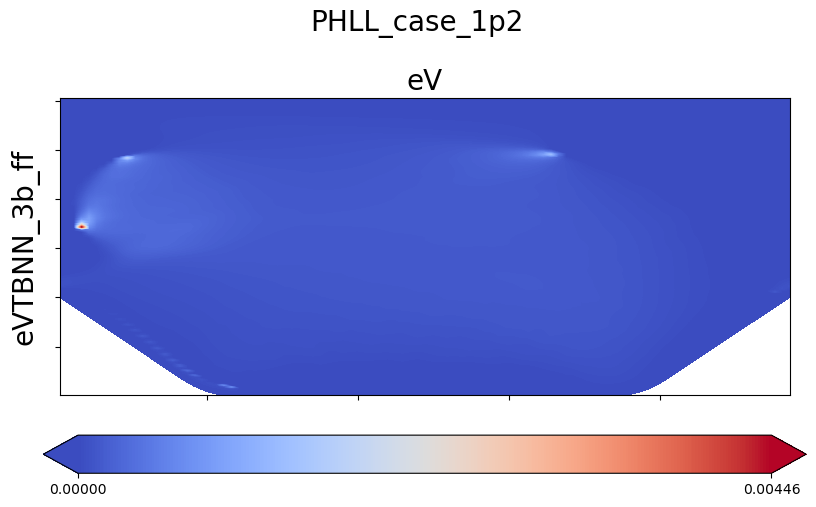

In [8]:
#plt.tricontourf(cX,cY, eV[:,0,0])
eV_plot(eV[:,0], cX, cY, case)

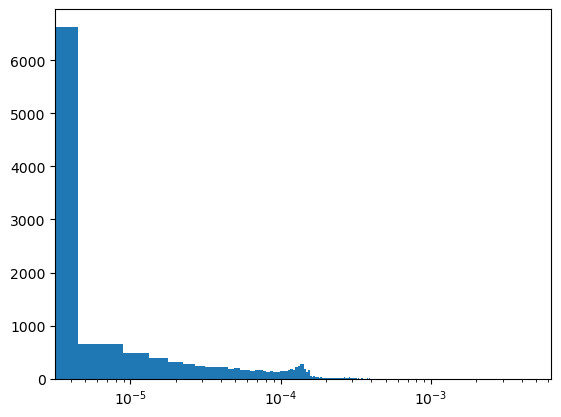

In [9]:
plt.hist(eV[:,0],bins=1000)
plt.xscale('log');

In [10]:
#path = os.path.join(parent_dir, directory)
st = time.time()

os.mkdir(os.path.join(parent_directory, basis_name)) 
print(f'Folder {basis_name} was sucessfully created\n')
    
for case in cases:   
    # print(f'Generating data for {case}')
    Tensor_Basis = build_47_tensors_basis([case])
    print(f'Tensor_Basis generated')
    I1 = build_47_I1(Tensor_Basis)
    print(f'I1 generated')
    I2 = build_47_I2(Tensor_Basis, I1)
    print(f'I2 generated')
    q = loadCombinedArray([case], 'q')
    
    S_DNS = build_S_DNS(case)
    print(f'S_DNS generated')
    
    cX = loadCombinedArray([case], 'Cx')
    cY = loadCombinedArray([case], 'Cy')
    #k_RANS = loadCombinedArray([case], 'k')
    #k_RANS = np.delete(k_RANS.reshape((len(k_RANS),9)),[2, 3 , 5, 6, 7,8],axis=1)
    
    #Shat = loadCombinedArray([case], 'S')
    #Shat = np.delete(Shat.reshape((len(Shat),9)),[2, 3 , 5, 6, 7, 8],axis=1)
    
    #Shat_K_RANS = np.concatenate([Shat[i]/k_RANS[i] for i in range(len(Shat))]).reshape(len(Shat), 3)
    
    b = loadLabels([case], 'b')
    b = np.delete(b.reshape((len(b),9)),[2, 3 , 5, 6, 7],axis=1)
    a = build_a([case]) 
    a = np.delete(a.reshape((len(a),9)),[2, 3 , 5, 6, 7],axis=1)
    
    eV = regress_eV(a, S_DNS)
    print(f'eV generated')


    a_NL= 2*eV*S_DNS+a[:,:3]
    
    a_NL = np.transpose([a_NL[:,0], a_NL[:,1], a_NL[:,2], -a_NL[:,0] - a_NL[:,2]])

    print(a_NL)
   
    
    np.save(os.path.join(parent_directory, basis_name, f'{dataset}_{case}_Tensors'), Tensor_Basis)
    np.save(os.path.join(parent_directory, basis_name, f'{dataset}_{case}_I1'), I1)
    np.save(os.path.join(parent_directory, basis_name, f'{dataset}_{case}_I2'), I2)
    np.save(os.path.join(parent_directory, basis_name, f'{dataset}_{case}_q'), q)
    np.save(os.path.join(parent_directory, basis_name, f'{dataset}_{case}_a'), a)
    np.save(os.path.join(parent_directory, basis_name, f'{dataset}_{case}_a_NL'), a_NL)
    np.save(os.path.join(parent_directory, basis_name, f'{dataset}_{case}_eV'), eV)
    np.save(os.path.join(parent_directory, basis_name, f'{dataset}_{case}_S_DNS'), S_DNS)
    np.save(os.path.join(parent_directory, basis_name, f'{dataset}_{case}_Cx'), cX)
    np.save(os.path.join(parent_directory, basis_name, f'{dataset}_{case}_Cy'), cY)
    
    #np.save(os.path.join(parent_directory, basis_name, f'{dataset}_{case}_b'), b)
    # np.save(os.path.join(parent_directory, basis_name, f'{dataset}_{case}_Shat_K_RANS'), Shat_K_RANS)
    
    
    print(f'{case} All files have been saved sucessfully')
    
    Tensor_Basis_check = loadCombinedArray_47([case], 'Tensors')

    I1_check = loadCombinedArray_47([case], 'I1')
    I2_check = loadCombinedArray_47([case], 'I2')
    q_check = loadCombinedArray_47([case], 'q')
    a_check = loadCombinedArray_47([case], 'a')
    S_DNS_check = loadCombinedArray_47([case], 'S_DNS')
    eV_check = loadCombinedArray_47([case], 'eV')

    print(f'\nTensors Basis\n Saved Shape: {Tensor_Basis.shape} Loaded Shape: {Tensor_Basis_check.shape}\n')
    print(f'\nS_DNS\n Saved Shape: {S_DNS.shape} Loaded Shape: {S_DNS_check.shape}\n')
    print(f'I1\n Saved Shape: {I1.shape} Loaded Shape: {I1_check.shape}\n')
    print(f'\nI2\n Saved Shape: {I2.shape} Loaded Shape: {I2_check.shape}\n')
    print(f'\nq\n Saved Shape: {q.shape} Loaded Shape: {q_check.shape}\n')
    print(f'\na\n Saved Shape: {a.shape} Loaded Shape: {a_check.shape}\n')
    print(f'\neV\n Saved Shape: {eV.shape} Loaded Shape: {eV_check.shape}\n')
    
    if (I1.shape != I1_check.shape) or (I2.shape != I2_check.shape) or (Tensor_Basis.shape != Tensor_Basis_check.shape) or (q.shape != q_check.shape) or (S_DNS.shape != S_DNS_check.shape) or (eV.shape != eV_check.shape) :
        print('Saving Aborted Check for Errors\n')
        break

    print('\n ============================================= ')
et = time.time()
elapsed_time = et - st
print('\n\nprocess Concluded\nExecution time:', elapsed_time, 'seconds')

Folder a_3_1_2_NL_S_DNS_eV_01 was sucessfully created

Tensor_Basis generated
I1 generated
I2 generated
S_DNS generated
eV generated
[[ 5.02557683e-07  1.26917000e-08 -4.06117367e-07 -9.64403167e-08]
 [ 5.02254617e-07  1.28566000e-08 -4.07891233e-07 -9.43633833e-08]
 [ 5.01843467e-07  1.30035000e-08 -4.09695933e-07 -9.21475333e-08]
 ...
 [-1.62335380e-08 -6.51633464e-08 -2.51594966e-08  4.13930346e-08]
 [ 1.67195900e-08 -1.14698318e-07 -1.92779942e-07  1.76060352e-07]
 [ 6.01694550e-07 -8.76537991e-08 -8.80661917e-07  2.78967367e-07]]
PHLL_case_0p5 All files have been saved sucessfully

Tensors Basis
 Saved Shape: (14751, 20, 3, 3) Loaded Shape: (14751, 20, 3, 3)


S_DNS
 Saved Shape: (14751, 3) Loaded Shape: (14751, 3)

I1
 Saved Shape: (14751, 20) Loaded Shape: (14751, 20)


I2
 Saved Shape: (14751, 20) Loaded Shape: (14751, 20)


q
 Saved Shape: (14751, 4) Loaded Shape: (14751, 4)


a
 Saved Shape: (14751, 4) Loaded Shape: (14751, 4)


eV
 Saved Shape: (14751, 1) Loaded Shape: (1475

In [11]:
if TroubleShoot:
    print(Tensor_Basis.shape)
    print('\n')
    print(Tensor_Basis[:,1])
    
    I1 = loadCombinedArray(cases, 'I1')
    print(I1.shape)
    I1_calc = build_47_I1(Tensor_Basis)
    print(I1[2,-1])
    print(I1_calc[2,-1])

    I2 = loadCombinedArray(cases, 'I2')
    print(I1.shape)
    I2_calc = build_47_I2(Tensor_Basis, I1_calc)
    print(I2[0,5])
    print(I2_calc[0,5])
